# Vector AutoRegressive Models

In [49]:
import numpy as np
import pandas as pd
import importlib
from pandas import DataFrame as df

from functions import vectorautoregressive as var
import functions.autoregressive as ar

In [40]:
importlib.reload(var)

<module 'functions.vectorautoregressive' from 'c:\\Users\\alber\\python_projects\\fundamentals_of_interest_rates\\functions\\vectorautoregressive.py'>

# Vector Autoregression (VAR)

## Definition of VAR(p)

A VAR(p) model is defined as:

$$
y_t = A_0 + A_1 y_{t-1} + \dots + A_p y_{t-p} + \varepsilon_t
$$

where:

- $y_t \in \mathbb{R}^{N \times 1}$  
- $A_i \in \mathbb{R}^{N \times N}, \quad \forall i$  
- $\varepsilon_t \in \mathbb{R}^{N \times 1}$  

with

$$
\mathbb{E}[\varepsilon_t] = 0, \quad 
\mathbb{E}[\varepsilon_t \varepsilon_\tau'] = 
\begin{cases} 
\Omega & t = \tau \\
0 & t \neq \tau
\end{cases}
$$

where $\Omega$ is a positive definite matrix.

---

## Recursive Representation

Expanding recursively the VAR(p):

$$
y_t = A_0 + A_1 y_{t-1} + \varepsilon_t
$$

$$
y_t = A_0 + A_1 (A_0 + A_1 y_{t-2} + \varepsilon_{t-1}) + \varepsilon_t
= A_0 + A_1 A_0 + A_1^2 y_{t-2} + \varepsilon_t + A_1 \varepsilon_{t-1}
$$

$$
y_t = \dots
$$

$$
y_t = A_0 + A_1 A_0 + \dots + A_1^{k-1} y_{t-k} + \varepsilon_t + A_1 \varepsilon_{t-1} + \dots + A_1^{k-1} \varepsilon_{t-k+1}
$$

The expected value:

$$
\mathbb{E}[y_t] = \sum_{j=0}^{k-1} A_1^j A_0 + A_1^k \mathbb{E}[y_{t-k}]
$$

> Note: The value of this sum depends on the behavior of $A_1^j$ as $j$ increases.

---


## Companion Matrix

We can rewrite a VAR(p) as a VAR(1) using the **companion matrix**:

$$
Y_t =
\begin{pmatrix}
y_t \\
y_{t-1} \\
\vdots \\
y_{t-p+1}
\end{pmatrix}, 
\quad
F =
\begin{pmatrix}
A_1 & A_2 & \dots & A_{p-1} & A_p \\
I & 0 & \dots & 0 & 0 \\
0 & I & \dots & 0 & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \dots & I & 0
\end{pmatrix}
$$

so that:

$$
Y_t = A_0^* + F Y_{t-1} + E_t
$$

with

$$
A_0^* = \begin{pmatrix} A_0 \\ 0 \\ \vdots \\ 0 \end{pmatrix}, \quad
E_t = \begin{pmatrix} \varepsilon_t \\ 0 \\ \vdots \\ 0 \end{pmatrix}
$$

---

## Stationarity Condition

A VAR(p) is stationary **if and only if** all eigenvalues of the companion matrix $F$ lie inside the unit circle:

$$
|\lambda_i(F)| < 1, \quad \forall i
$$

- This ensures shocks die out over time and the process does not explode.  
- The eigenvalues of $F$ are exactly the roots of the **characteristic equation** of the VAR(p):

$$
\det(I_N z^p - A_1 z^{p-1} - \dots - A_p) = 0
$$

> Checking eigenvalues of $F$ is a practical way to verify stationarity.



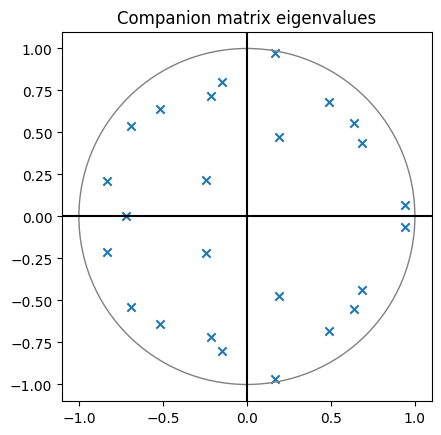

In [58]:
k = 5
p = 5
T = 1000


A = var.generate_A_stationary(k, p, plot_eigs=True, diag_dominant=False, offdiag_scale=0.5)

In [59]:
sigma = var.generate_sigma(k, bounds=(0.1, 1.0))
data = var.generate_var(T, k, p, sigma, A, A_0=np.full(shape=(k), fill_value=10))

100%|██████████| 995/995 [00:00<00:00, 138704.22it/s]


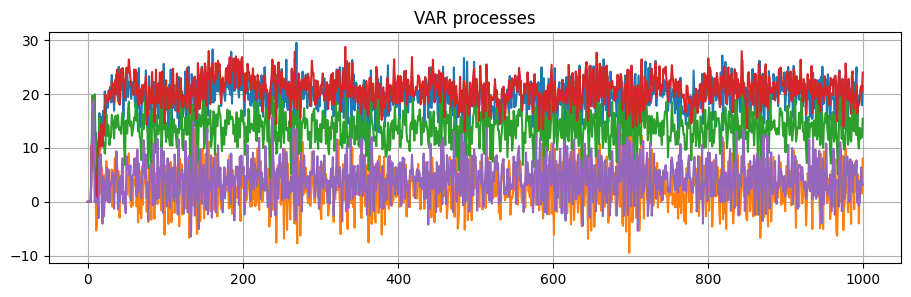

In [60]:
ar.plot_paths(data, title='VAR processes')

## Covariance Stationarity

A VAR(p) process is **covariance stationary** if:

- The mean $\mathbb{E}[y_t]$ is constant over time  
- The covariance $\text{Cov}(y_t, y_{t-h})$ depends only on the lag $h$

If the process is stationary, the mean can be computed as:

$$
\mu = \mathbb{E}[y_t] = A_0 + A_1 \mu + \dots + A_p \mu
$$

$$
\mu = \left(I_N - A_1 - \dots - A_p\right)^{-1} A_0 
$$


Let's check if the sample mean converges to theoretical, for semplicity let's keep $A_{0}^{i}$ equal for every asset $i$ 

In [62]:
def theoretical_mean(A0, A):
    p, k, _ = A.shape
    I = np.eye(k)
    return np.linalg.inv(I - np.sum(A, axis=0)) @ A0

In [ ]:
steps_list = [100, 1000, 10_000, 100_000]
a_0 = 1
A_0=np.full(shape=(k), fill_value=a_0)

simulations = var.iterate_simulations(steps_list, k, p,  A, sigma, A_0=A_0)

In [75]:
sample_means = [np.mean(sim, axis=0).mean() for sim in simulations.values()]

th_mean = theoretical_mean(A0=A_0, A=A)

result = df({'steps': steps_list,'sample_mean': sample_means})
result['sample_mean'] = result['sample_mean'].round(6)

result = pd.concat([result, df({'steps': ['theoretical'], 'sample_mean': [th_mean.mean()]})], ignore_index=True)
display(result)

,steps,sample_mean
0,100,1.081161
1,1000,1.184559
2,10000,1.188032
3,100000,1.215843
4,theoretical,1.224738
